# Truth


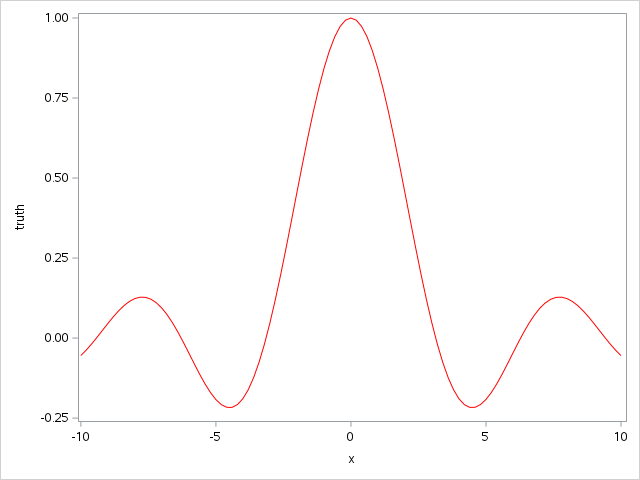

In [3]:
data truth;
do x = -10 to 10 by .2;
   if x ^= 0 then do; /* avoid division by 0 */
     truth = sin(x) / x; 
     output;
     end;
end;
run;


proc sgplot data=truth;
  series x=x y=truth / lineattrs=(color=red);
run;quit;  

# Data 


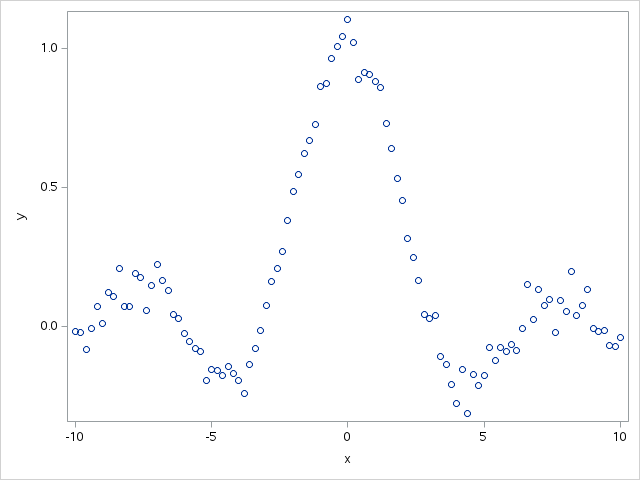

In [4]:
/* random data with noise and pattern */
data h;
set truth;
y = truth + rand('normal',0,.05);
output;
run;

proc sgplot data=h;
  scatter x=x y=y;
run;quit;  

# Manual Kernel, OLS, Prediction


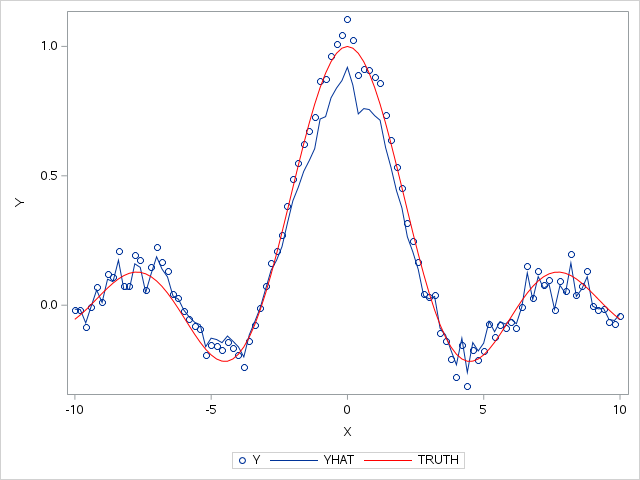

In [7]:
/* plot predictions versus orig */

/* get num obs */
data _null_;call symputx('n',nobs);set h nobs=nobs;stop;run;

/* instead of single x, make an (expensive) square matrix */
data square;
   array xv[&n];
   array yv[&n];
   array r[&n];
   array tv[&n];
   do i = 1 to &n;
      set h;
      xv[i] = x; yv[i] = y; tv[i]=truth;
   end;   
   do i = 1 to &n;
      do j = 1 to &n;
         r[j] = exp(-100.01*(xv[i]-xv[j])**2); /* kernel */
      end;
      y = yv[i];
      x = xv[i];
      truth = tv[i];
      output;
   end;
   keep x y r: truth;
run;  

/* invert the square matrix, adding .1 to diagonal */ 
proc iml;
   use square;
   read all var {x y truth};
   read all var("r1":"r&n") into r[colName=varNames];
   close;
   rnew = r + .1 # i(&n); /* add .1 to diagonal */
   beta = inv(t(rnew)*rnew)*t(r)*y; /* beta = inv(xpx) xp y */
   yhat = r * beta;
   create foo var {yhat x y truth}; append; close foo;
quit;
/* plot predictions versus orig */
proc sgplot data=foo;
  scatter x=x y=y;
  series x=x y=yhat;
  series x=x y=truth / lineattrs=(color=red);
run;quit; 

In [6]:
proc print data=square;
var r1-r10;
run;


Obs,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10
1,1.00000,0.99960,0.99840,0.99641,0.99362,0.99005,0.98570,0.98059,0.97472,0.96812
2,0.99960,1.00000,0.99960,0.99840,0.99641,0.99362,0.99005,0.98570,0.98059,0.97472
3,0.99840,0.99960,1.00000,0.99960,0.99840,0.99641,0.99362,0.99005,0.98570,0.98059
4,0.99641,0.99840,0.99960,1.00000,0.99960,0.99840,0.99641,0.99362,0.99005,0.98570
5,0.99362,0.99641,0.99840,0.99960,1.00000,0.99960,0.99840,0.99641,0.99362,0.99005
6,0.99005,0.99362,0.99641,0.99840,0.99960,1.00000,0.99960,0.99840,0.99641,0.99362
7,0.98570,0.99005,0.99362,0.99641,0.99840,0.99960,1.00000,0.99960,0.99840,0.99641
8,0.98059,0.98570,0.99005,0.99362,0.99641,0.99840,0.99960,1.00000,0.99960,0.99840
9,0.97472,0.98059,0.98570,0.99005,0.99362,0.99641,0.99840,0.99960,1.00000,0.99960
10,0.96812,0.97472,0.98059,0.98570,0.99005,0.99362,0.99641,0.99840,0.99960,1.00000
